## Conjugate Priors

In [90]:
import pandas as pd 
import numpy as np 
from typing import List, Dict, Tuple, Optional
import copy 
from collections import Counter
from scipy import stats
# Go up one level
# from the current working directory
import os 
import sys 
# Get current working directory (where notebook is run)
current_dir = os.getcwd()

# Move two levels up
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add to sys.path if not already there
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import run  # Now this should work!
import utils_adni
import json 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import yaml 

import pysaebm.utils.data_processing as data_utils 
from pyebm import debm
from pyebm import ebm
from typing import List, Dict, Tuple, Optional
from kde_ebm import mixture_model
from kde_ebm import mcmc
from kde_ebm.mixture_model import get_prob_mat
from scipy.stats import kendalltau
from collections import defaultdict, namedtuple
import yaml
from kde_ebm.plotting import mcmc_uncert_mat

In [91]:
meta_data = ['PTID', 'DX_bl', 'VISCODE', 'COLPROT']

select_biomarkers = ['MMSE_bl', 'Ventricles_bl', 'WholeBrain_bl', 
            'MidTemp_bl', 'Fusiform_bl', 'Entorhinal_bl', 
            'Hippocampus_bl', 'ADAS13_bl', 'PTAU_bl', 
            'TAU_bl', 'ABETA_bl', 'RAVLT_immediate_bl'
]

diagnosis_list = ['CN', 'EMCI', 'LMCI', 'AD']

OUTPUT_DIR = parent_dir

raw = f'{OUTPUT_DIR}/ADNIMERGE.csv'

In [92]:
def load_config():
    config_path = os.path.join(parent_dir, "config.yaml")
    
    with open(config_path, "r") as f:
        return yaml.safe_load(f)
config = load_config()
print("Loaded config:")
print(json.dumps(config, indent=4))

Loaded config:
{
    "N_VARIANTS": 50,
    "NStartpoints": 10,
    "Niterations": 1000,
    "N_MCMC": 10000,
    "N_SHUFFLE": 2,
    "BURN_IN": 500,
    "THINNING": 1,
    "GEN_SEED": 42,
    "JS": [
        50,
        200,
        500,
        1000
    ],
    "MCMC_SEED": 53,
    "RS": [
        0.1,
        0.25,
        0.5,
        0.75,
        0.9
    ],
    "N_BOOTSTRAP": 50,
    "SA_EBM_ALGO_NAMES": [
        "conjugate_priors",
        "mle",
        "kde",
        "em",
        "hard_kmeans"
    ],
    "OTHER_ALGO_NAMES": [
        "debm",
        "debm_gmm",
        "ucl_gmm",
        "ucl_kde"
    ],
    "OUTPUT_DIR": "algo_results",
    "EXPERIMENT_NAMES": [
        "sn_kjOrdinalDM_xnjNormal",
        "sn_kjOrdinalDM_xnjNonNormal",
        "sn_kjOrdinalUniform_xnjNormal",
        "sn_kjOrdinalUniform_xnjNonNormal",
        "sn_kjContinuousUniform",
        "sn_kjContinuousBeta",
        "xiNearNormal_kjContinuousUniform",
        "xiNearNormal_kjContinuousBeta",
        "

In [93]:
SA_EBM_ALGO_NAMES = config['SA_EBM_ALGO_NAMES']
OTHER_ALGO_NAMES = config['OTHER_ALGO_NAMES']
ALL_ALGOS = SA_EBM_ALGO_NAMES + OTHER_ALGO_NAMES
ALGONAMES = [
    'Conjugate Priors', "MLE", 'KDE', 'EM', 'Hard K-Means',
    'DEBM', 'DEBM GMM', 'UCL GMM', 'UCL KDE']
CONVERT_ALGO_DICT = {k.lower(): v for k, v in zip(ALL_ALGOS, ALGONAMES)}

In [94]:
adni_filtered = utils_adni.get_adni_filtered(raw, meta_data, select_biomarkers, diagnosis_list)
debm_output, data_matrix, data_we_have, participant_dx_dict, ordered_biomarkers = utils_adni.process_data(
    adni_filtered, ventricles_log=False, tau_log=False)
data_we_have.head()

726
No duplicates!
AD: 153 (21.1%)
LMCI: 236 (32.5%)
CN: 155 (21.3%)
EMCI: 182 (25.1%)
----------------------------------------------------
ADNI1: 275 (37.9%)
ADNI2: 375 (51.7%)
ADNIGO: 76 (10.5%)


,participant,diseased,biomarker,measurement
0,0,True,ADAS13,31.00
1,1,False,ADAS13,21.33
2,2,False,ADAS13,14.67
3,3,True,ADAS13,24.33
4,4,False,ADAS13,8.33


In [95]:
def get_ml_stages_and_plot(algo_name:str, participant_dx_dict:Dict[int, str] = participant_dx_dict):
    if algo_name in SA_EBM_ALGO_NAMES:
        results_json = 'adni_results.json'
    else:
        results_json = 'results.json'
    file_source = os.path.join(parent_dir, "adni_results", algo_name, "results", results_json)
    with open(file_source, 'r') as f:
        result = json.load(f)
    runtime = result['runtime']
    ml_stages = result['ml_stages']
    ml_stages_plot = utils_adni.plot_staging(ml_stages, participant_dx_dict, algorithm=CONVERT_ALGO_DICT[algo_name])
    return ml_stages, ml_stages_plot, runtime

## Conjugate Priors

In [96]:
cp_stages, ml_stages_plot, cp_runtime = get_ml_stages_and_plot('conjugate_priors')
ml_stages_plot

alt.LayerChart(...)

In [97]:
dff = pd.DataFrame({'Category': list(participant_dx_dict.values()), 'Value': cp_stages})

# Group by category and calculate mean
result = dff.groupby('Category')['Value'].mean()

# Convert to table format (optional)
result_table = result.reset_index()

print(result_table)

  Category     Value
0       AD  9.307190
1       CN  1.032258
2     EMCI  2.752747
3     LMCI  5.940678


## MLE

In [98]:
mle_stages, ml_stages_plot, mle_runtime = get_ml_stages_and_plot('mle')
ml_stages_plot

alt.LayerChart(...)

## EM

In [99]:
em_stages, ml_stages_plot, em_runtime = get_ml_stages_and_plot('em')
ml_stages_plot

alt.LayerChart(...)

## Hard K-Means

In [100]:
hk_stages, ml_stages_plot, hk_runtime = get_ml_stages_and_plot('hard_kmeans')
ml_stages_plot

alt.LayerChart(...)

## KDE

In [101]:
kde_stages, ml_stages_plot, kde_runtime = get_ml_stages_and_plot('kde')
ml_stages_plot

alt.LayerChart(...)

## UCL GMM

In [102]:
ucl_gmm_stages, ml_stages_plot, ucl_gmm_runtime = get_ml_stages_and_plot('ucl_gmm')
ml_stages_plot

alt.LayerChart(...)

## DEBM

In [103]:
debm_stages, ml_stages_plot, debm_runtime = get_ml_stages_and_plot('debm')
ml_stages_plot

alt.LayerChart(...)

## DEBM GMM

In [104]:
debm_gmm_stages, ml_stages_plot, debm_gmm_runtime = get_ml_stages_and_plot('debm_gmm')
ml_stages_plot

alt.LayerChart(...)

## Runtime 

In [105]:
cp_runtime

5152.616723537445

In [106]:
runtime_dict = {
    'Conjugate Priors': cp_runtime,
    'MLE': mle_runtime,
    # 'EM': em_runtime,
    # 'Hard K-Means': hk_runtime,
    # 'KDE': kde_runtime,
    'UCL GMM': ucl_gmm_runtime,
    'DEBM': debm_runtime,
    'DEBM GMM': debm_gmm_runtime,
}
runtime_dict = {k:v/60 for k, v in runtime_dict.items()}
runtime_dict

{'Conjugate Priors': 85.87694539229075,
 'MLE': 83.97547430197397,
 'UCL GMM': 0.1724215547243754,
 'DEBM': 0.1612375577290853,
 'DEBM GMM': 0.3148810029029846}

In [107]:
df = pd.DataFrame({
    'Conjugate Priors': cp_stages,
    'MLE': mle_stages,
    'EM': em_stages,
    'Hard K-Means': hk_stages,
    'KDE': kde_stages,
    'UCL GMM': ucl_gmm_stages,
    'DEBM': debm_stages,
    'DEBM GMM': debm_gmm_stages,
    'DX': list(participant_dx_dict.values())
})
df.head()

# Algorithm names
algorithms = ['Conjugate Priors', 'MLE', 'EM', 'Hard K-Means', 'KDE', 'UCL GMM', 'DEBM', 'DEBM GMM']

Summary Statistics by Diagnostic Group:
                      mean                                               \
algorithm Conjugate Priors   DEBM DEBM GMM      EM Hard K-Means     KDE   
DX                                                                        
AD                   9.307  8.098    9.523  11.222        9.922  10.346   
CN                   1.032  1.006    1.342   1.968        1.116   0.923   
EMCI                 2.753  2.187    2.665   3.198        2.841   2.929   
LMCI                 5.941  5.085    5.754   7.093        6.572   6.987   

                                      var                           \
algorithm    MLE UCL GMM Conjugate Priors    DEBM DEBM GMM      EM   
DX                                                                   
AD         9.575  10.033            5.543   6.300    3.870   3.437   
CN         0.955   2.071            3.304   2.812    3.551   4.525   
EMCI       2.324   4.088           11.215   8.683    9.517  13.242   
LMCI       5.7

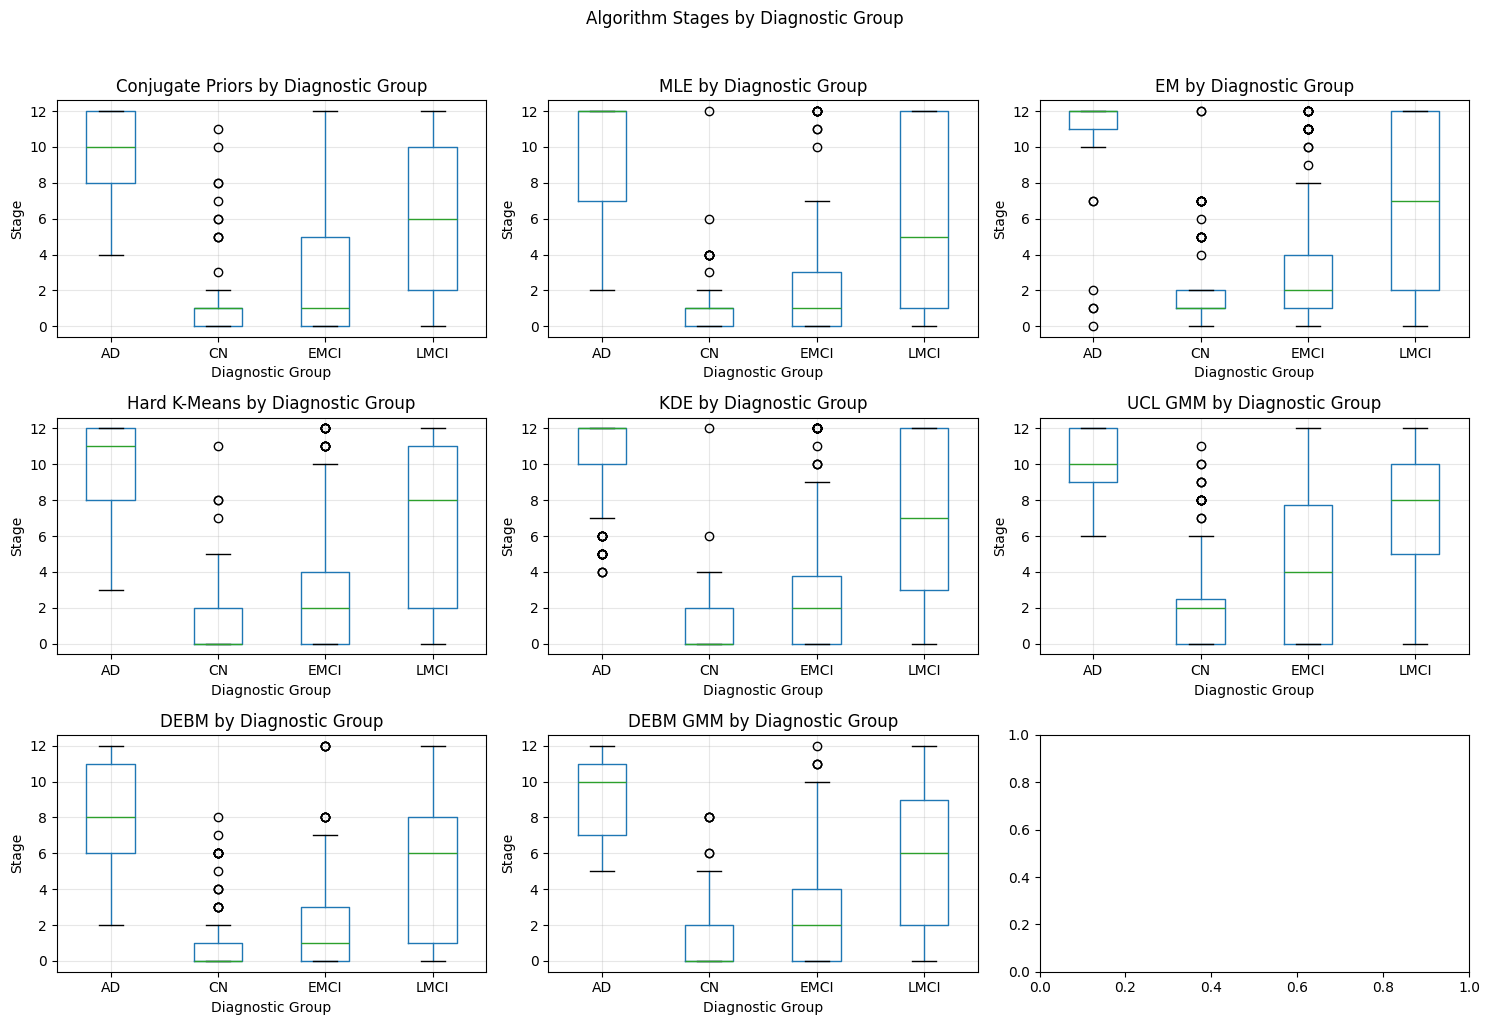

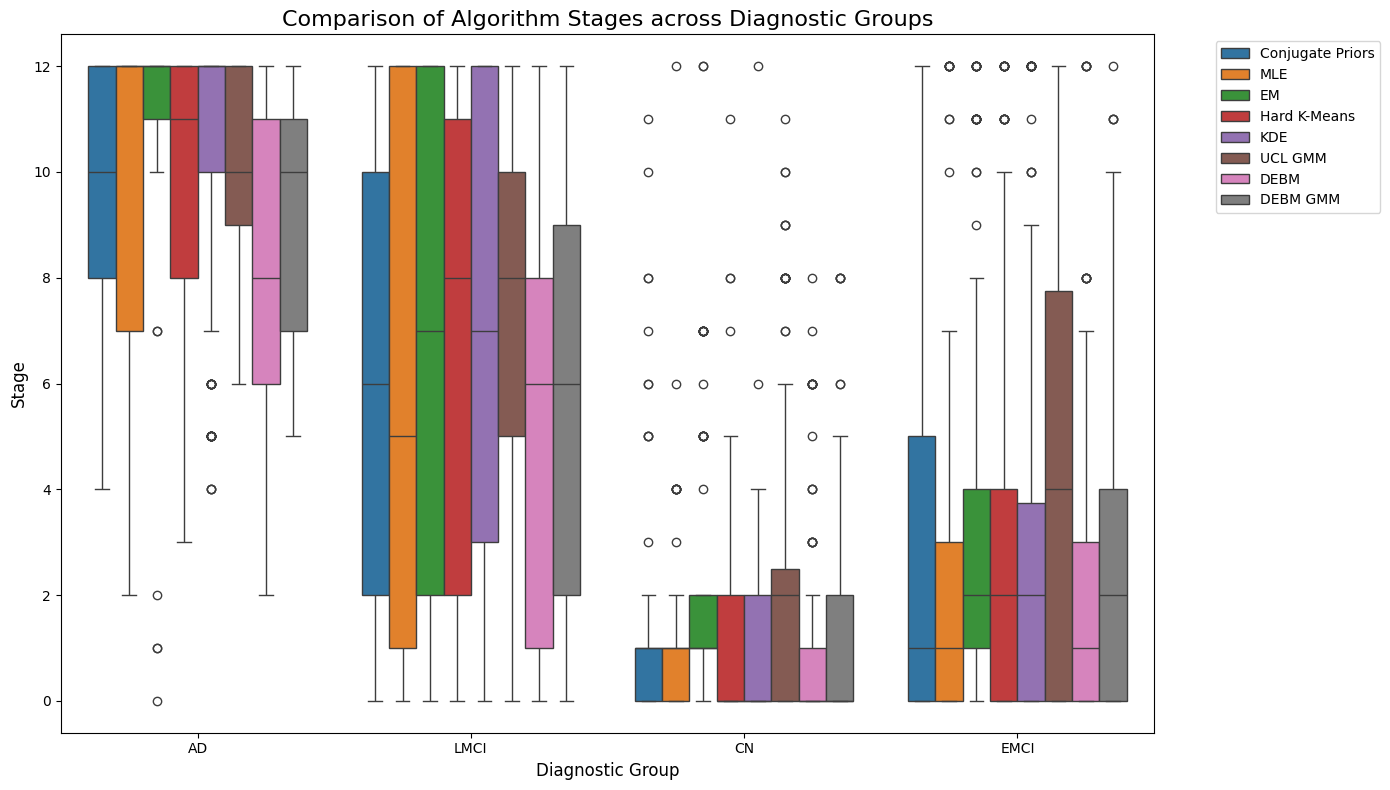


=== Statistical Analysis ===

Conjugate Priors:
  F-statistic: 214.6211
  p-value: 0.0000
  Post-hoc Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    AD     CN  -8.2749   0.0 -9.1986 -7.3513   True
    AD   EMCI  -6.5544   0.0 -7.4434 -5.6655   True
    AD   LMCI  -3.3665   0.0 -4.2077 -2.5253   True
    CN   EMCI   1.7205   0.0  0.8347  2.6063   True
    CN   LMCI   4.9084   0.0  4.0705  5.7463   True
  EMCI   LMCI   3.1879   0.0  2.3884  3.9875   True
---------------------------------------------------

MLE:
  F-statistic: 204.0740
  p-value: 0.0000
  Post-hoc Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AD     CN  -8.6203    0.0 -9.6198 -7.6208   True
    AD   EMCI   -7.251    0.0 -8.2129  -6.289   True
    AD   LMCI  -3.8167    0.0  -

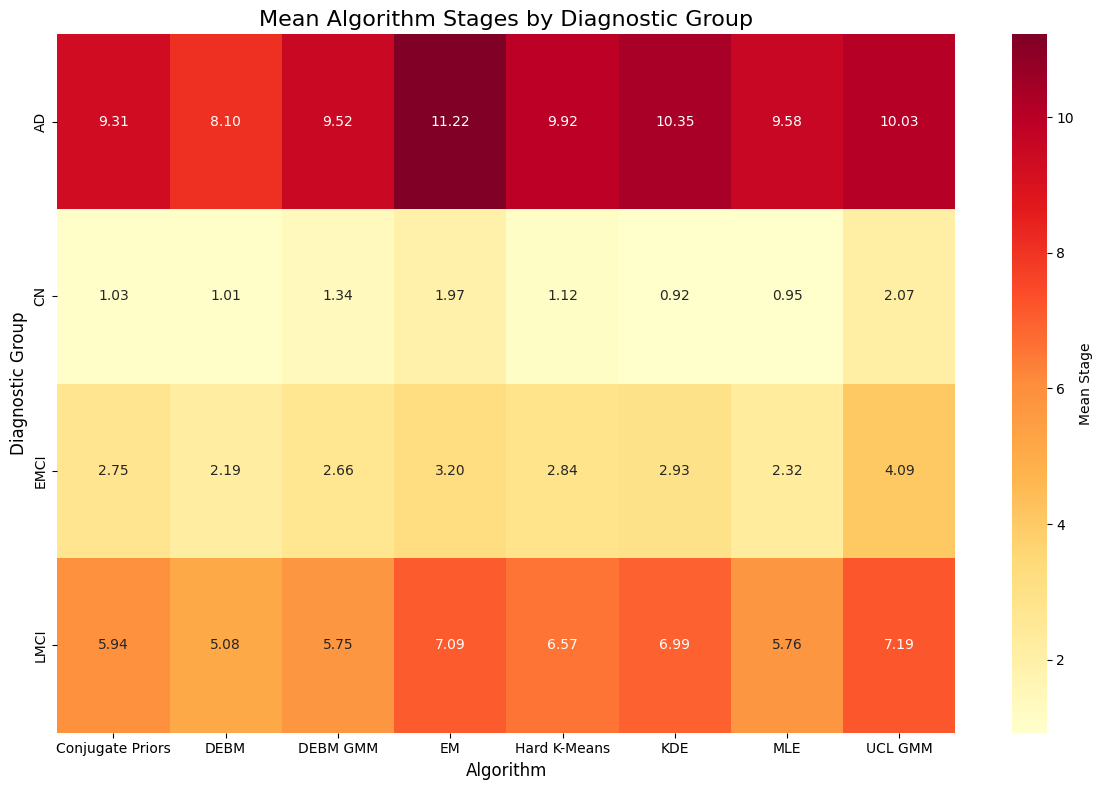

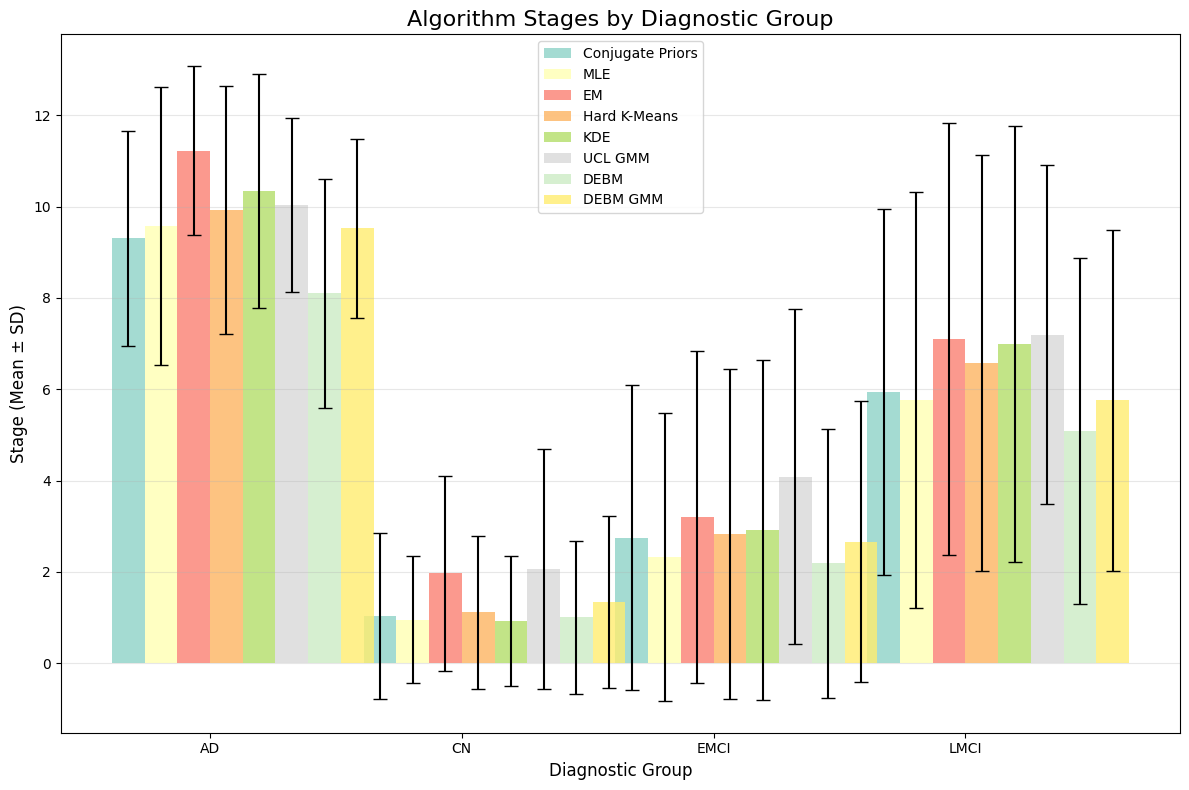


=== Effect Sizes (Eta-squared) ===
Conjugate Priors: η² = 0.4714
MLE: η² = 0.4589
EM: η² = 0.4862
Hard K-Means: η² = 0.4587
KDE: η² = 0.4826
UCL GMM: η² = 0.4467
DEBM: η² = 0.4326
DEBM GMM: η² = 0.5065


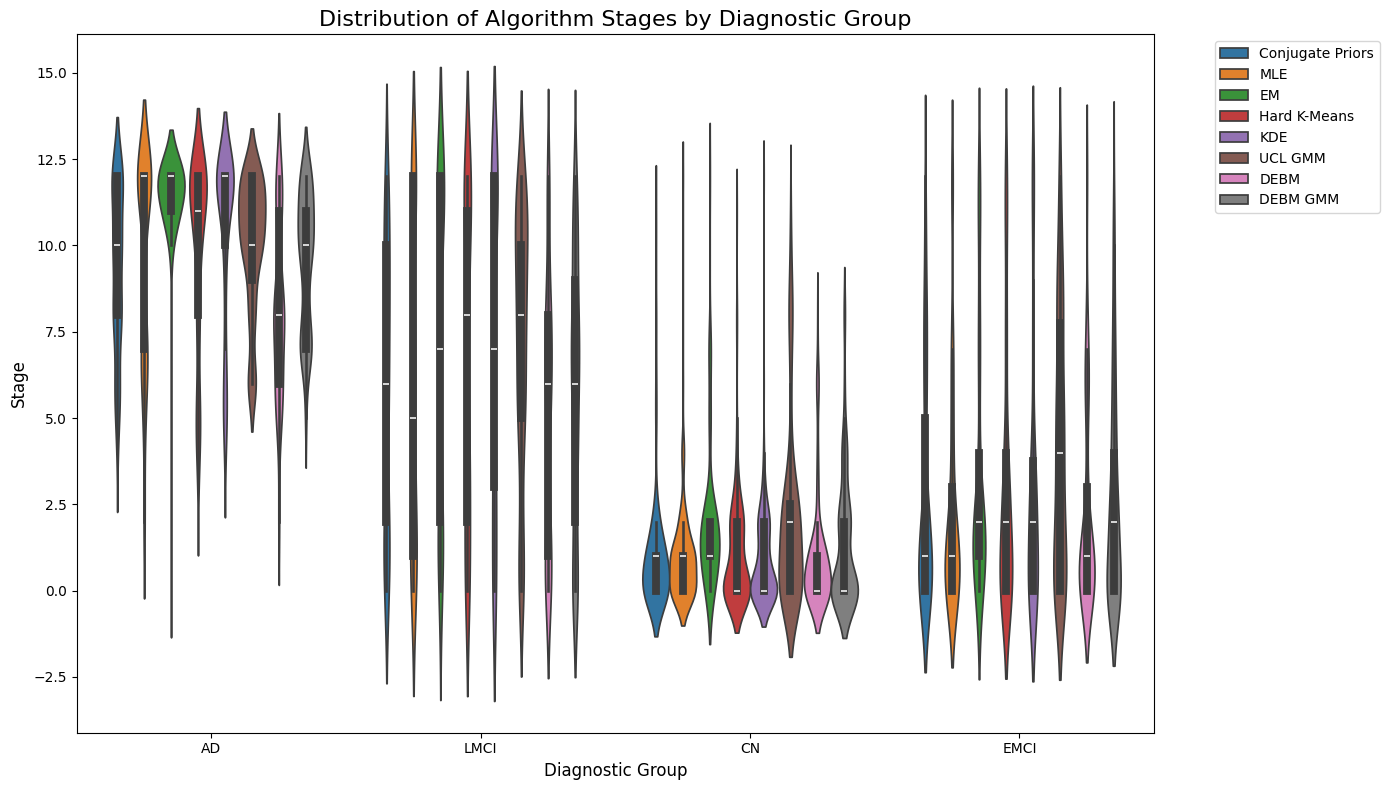


Analysis complete! Files saved:
- algorithm_summary_stats.csv
- anova_results.csv
- effect_sizes.csv
- analysis_report.txt
- individual_boxplots.png
- grouped_boxplot.png
- mean_heatmap.png
- error_bar_plot.png
- violin_plot.png


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 1. Calculate mean and variance for each algorithm by diagnostic group
summary_stats = []

for algo in algorithms:
    stats_by_dx = df.groupby('DX')[algo].agg(['mean', 'var', 'count'])
    stats_by_dx['algorithm'] = algo
    stats_by_dx = stats_by_dx.reset_index()
    summary_stats.append(stats_by_dx)

# Combine all statistics
all_stats = pd.concat(summary_stats)

# Create a formatted summary table
summary_pivot = all_stats.pivot_table(
    index='DX', 
    columns='algorithm', 
    values=['mean', 'var']
)

print("Summary Statistics by Diagnostic Group:")
print(summary_pivot.round(3))

# Save summary to CSV
# summary_pivot.to_csv('algorithm_summary_stats.csv')

# 2. Create boxplots
# Method 1: Individual boxplots for each algorithm
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, algo in enumerate(algorithms):
    df.boxplot(column=algo, by='DX', ax=axes[idx])
    axes[idx].set_title(f'{algo} by Diagnostic Group')
    axes[idx].set_xlabel('Diagnostic Group')
    axes[idx].set_ylabel('Stage')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Algorithm Stages by Diagnostic Group', y=1.02)
plt.tight_layout()
# plt.savefig('individual_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Method 2: Grouped boxplot (all algorithms together)
# Reshape data for grouped plotting
df_melted = df.melt(
    id_vars=['DX'], 
    value_vars=algorithms,
    var_name='Algorithm', 
    value_name='Stage'
)

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='DX', y='Stage', hue='Algorithm')
plt.title('Comparison of Algorithm Stages across Diagnostic Groups', fontsize=16)
plt.xlabel('Diagnostic Group', fontsize=12)
plt.ylabel('Stage', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('grouped_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Statistical testing - ANOVA for continuous data
results_table = []

print("\n=== Statistical Analysis ===")
for algo in algorithms:
    # Group data by diagnosis
    groups = [group[algo].values for name, group in df.groupby('DX')]
    
    # Perform one-way ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    results_table.append({
        'Algorithm': algo,
        'F-statistic': f_stat,
        'p-value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    
    print(f"\n{algo}:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    # If significant, perform post-hoc test
    if p_value < 0.05:
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        tukey = pairwise_tukeyhsd(endog=df[algo], groups=df['DX'], alpha=0.05)
        print("  Post-hoc Tukey HSD:")
        print(tukey)

anova_results = pd.DataFrame(results_table)
print("\nANOVA Results Summary:")
print(anova_results)
# anova_results.to_csv('anova_results.csv', index=False)

# 4. Create a heatmap of mean values
mean_matrix = summary_pivot['mean']
plt.figure(figsize=(12, 8))
sns.heatmap(mean_matrix, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Mean Stage'})
plt.title('Mean Algorithm Stages by Diagnostic Group', fontsize=16)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Diagnostic Group', fontsize=12)
plt.tight_layout()
# plt.savefig('mean_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Create error bar plot
fig, ax = plt.subplots(figsize=(12, 8))
dx_groups = df['DX'].unique()
dx_groups_sorted = sorted(dx_groups)  # Sort for consistent ordering
x = np.arange(len(dx_groups_sorted))
width = 0.13

colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))

for i, algo in enumerate(algorithms):
    means = [df[df['DX'] == dx][algo].mean() for dx in dx_groups_sorted]
    stds = [df[df['DX'] == dx][algo].std() for dx in dx_groups_sorted]
    
    ax.bar(x + i*width, means, width, yerr=stds, label=algo, 
           capsize=5, color=colors[i], alpha=0.8)

ax.set_xlabel('Diagnostic Group', fontsize=12)
ax.set_ylabel('Stage (Mean ± SD)', fontsize=12)
ax.set_title('Algorithm Stages by Diagnostic Group', fontsize=16)
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(dx_groups_sorted)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
# plt.savefig('error_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Calculate effect sizes (eta-squared)
print("\n=== Effect Sizes (Eta-squared) ===")
def calculate_eta_squared(df, group_col, value_col):
    grouped = df.groupby(group_col)[value_col]
    grand_mean = df[value_col].mean()
    
    # Between-group sum of squares
    ss_between = sum(len(group) * (group.mean() - grand_mean)**2 
                     for name, group in grouped)
    
    # Total sum of squares
    ss_total = sum((df[value_col] - grand_mean)**2)
    
    return ss_between / ss_total

effect_sizes = []
for algo in algorithms:
    eta_sq = calculate_eta_squared(df, 'DX', algo)
    effect_sizes.append({'Algorithm': algo, 'Eta-squared': eta_sq})
    print(f"{algo}: η² = {eta_sq:.4f}")

effect_df = pd.DataFrame(effect_sizes)
# effect_df.to_csv('effect_sizes.csv', index=False)

# 7. Create a violin plot for distribution visualization
plt.figure(figsize=(14, 8))
sns.violinplot(data=df_melted, x='DX', y='Stage', hue='Algorithm', split=False)
plt.title('Distribution of Algorithm Stages by Diagnostic Group', fontsize=16)
plt.xlabel('Diagnostic Group', fontsize=12)
plt.ylabel('Stage', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('violin_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Create a summary report
with open('analysis_report.txt', 'w') as f:
    f.write("ALGORITHM COMPARISON ANALYSIS REPORT\n")
    f.write("="*40 + "\n\n")
    
    f.write("1. SUMMARY STATISTICS\n")
    f.write("-"*20 + "\n")
    for dx in df['DX'].unique():
        f.write(f"\n{dx}:\n")
        for algo in algorithms:
            subset = df[df['DX'] == dx][algo]
            f.write(f"  {algo}: Mean={subset.mean():.3f}, Var={subset.var():.3f}, n={len(subset)}\n")
    
    f.write("\n2. STATISTICAL TESTS\n")
    f.write("-"*20 + "\n")
    f.write(anova_results.to_string())
    
    f.write("\n\n3. EFFECT SIZES\n")
    f.write("-"*20 + "\n")
    f.write(effect_df.to_string())
    
    f.write("\n\n4. KEY FINDINGS\n")
    f.write("-"*20 + "\n")
    significant_algos = anova_results[anova_results['Significant'] == 'Yes']['Algorithm'].tolist()
    f.write(f"Algorithms showing significant differences: {', '.join(significant_algos)}\n")
    
    best_effect = effect_df.loc[effect_df['Eta-squared'].idxmax()]
    f.write(f"Algorithm with largest effect size: {best_effect['Algorithm']} (η² = {best_effect['Eta-squared']:.4f})\n")

print("\nAnalysis complete! Files saved:")
print("- algorithm_summary_stats.csv")
print("- anova_results.csv")
print("- effect_sizes.csv")
print("- analysis_report.txt")
print("- individual_boxplots.png")
print("- grouped_boxplot.png")
print("- mean_heatmap.png")
print("- error_bar_plot.png")
print("- violin_plot.png")

## ChatGPT

In [109]:
df_long = df.melt(id_vars='DX', 
                  var_name='Algorithm', 
                  value_name='Stage')

In [110]:
summary_stats = df_long.groupby(['Algorithm', 'DX'])['Stage'].agg(['mean', 'var']).sort_values(by=['DX']).reset_index()
# print(summary_stats)

In [111]:
algorithms

['Conjugate Priors',
 'MLE',
 'EM',
 'Hard K-Means',
 'KDE',
 'UCL GMM',
 'DEBM',
 'DEBM GMM']

In [112]:
for algo in algorithms:
    contingency_table = pd.crosstab(df[algo], df['DX'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"{algo}: Chi-square = {chi2:.4f}, p = {p_value:.4f}")

Conjugate Priors: Chi-square = 413.1443, p = 0.0000
MLE: Chi-square = 394.9347, p = 0.0000
EM: Chi-square = 409.4445, p = 0.0000
Hard K-Means: Chi-square = 406.7170, p = 0.0000
KDE: Chi-square = 453.7787, p = 0.0000
UCL GMM: Chi-square = 432.6019, p = 0.0000
DEBM: Chi-square = 373.1413, p = 0.0000
DEBM GMM: Chi-square = 441.8954, p = 0.0000
